## EY Data Challenge - Sentinel-2 Sample Notebook

This sample notebook can be used to create a Sentinel-2 satellite output product for a single date or a median mosaic for any time period. A median mosaic reflects the "median" value of pixels for all spectral bands in the time series. When scenes within a time series contain clouds, the use of a median calculation can statistically remove clouds from the final median mosaic product, assuming there are plenty of clear pixels within the time series. The output from this notebook is a GeoTIFF product suitable for further analysis and can also be used to generate spectral index products using mathematical combinations of bands, such as NDVI. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data from the MS Planetary Computer catalog.

In [1]:
!pip install stackstac odc-stac planetary-computer rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.4 MB/s eta 0:00:00


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates.

In [3]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [4]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [5]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [7]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters.

In [8]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [9]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

### Sentinel-2 Bands Summary
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [10]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [11]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 532MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above.

In [12]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

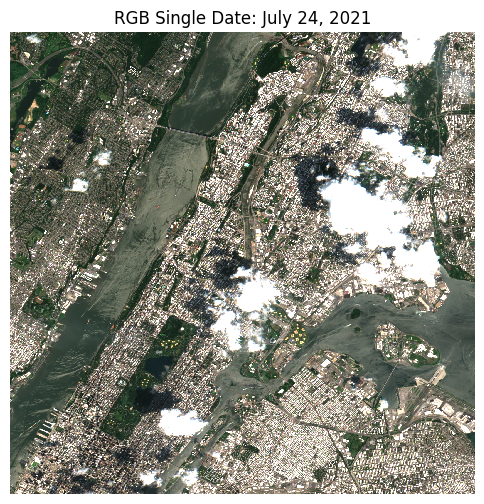

In [13]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=7).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

In [15]:
median = data.median(dim="time").compute()

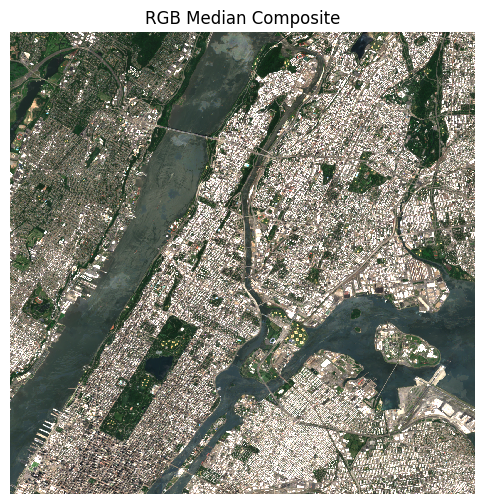

In [16]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [17]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

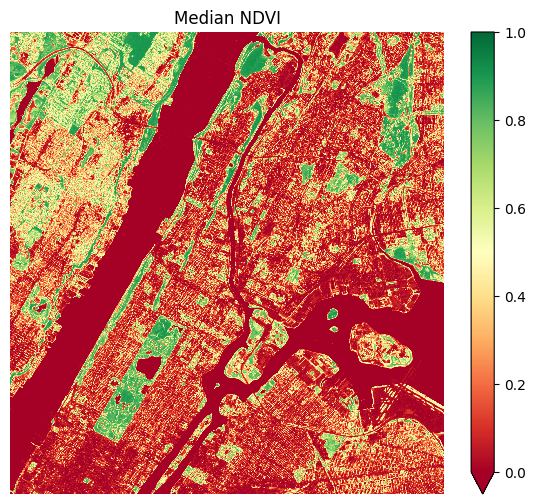

In [18]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [19]:
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

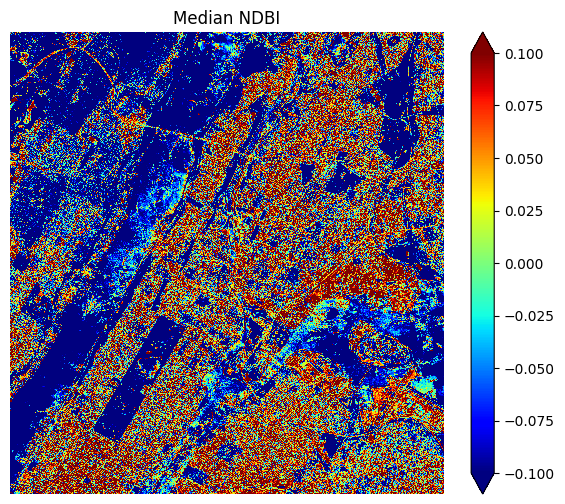

In [20]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [21]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

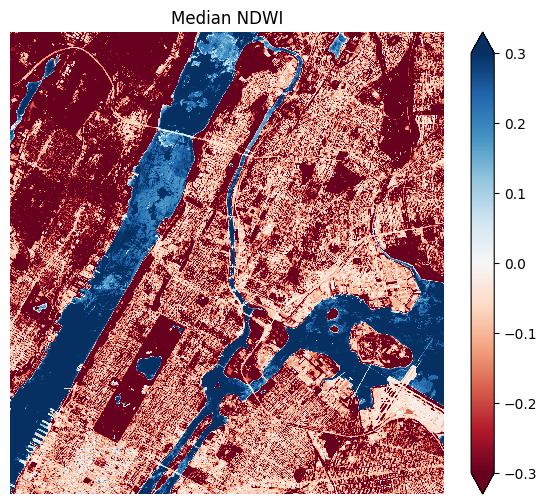

In [22]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file
We have selected a single date (July 24, 2021) to create a GeoTIFF output product. This date is the same as the ground temperature data collection date. Though this image contains some clouds, it will be used as the baseline for the benchmark notebook. Participants in the data challenge may desire to use other single scenes with less cloud cover or create a median mosaic that statistically filters the clouds over a time series stack of data (see the median dataset above).
<br><br>The output product below only contains 4 selected bands that are used in the benchmark notebook. Participants may choose to include all of the bands for their models to investigate how different bands and derived spectral indices change their model results.

In [33]:
filename = "S2_sample_all.tiff"

In [34]:
# We will pick a single time slice from the time series (time=7)
# This time slice is the date of July 24, 2021
data_slice = data.isel(time=7)

In [35]:
# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]

In [36]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

In [37]:
print(data_slice)

<xarray.Dataset> Size: 53MB
Dimensions:      (latitude: 1448, longitude: 1671)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    time         datetime64[ns] 8B 2021-07-24T15:49:11.024000
    spatial_ref  int64 8B 0
Data variables:
    B01          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B02          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B03          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B04          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B05          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B06          (latitude, longitude) uint16 5MB dask.array<chunksize=(1448, 1671), meta=np.ndarray>
    B07          (latitude, 

In [38]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B01,1)
    dst.write(data_slice.B02,2)
    dst.write(data_slice.B03,3)
    dst.write(data_slice.B04,4)
    dst.write(data_slice.B05,5)
    dst.write(data_slice.B06,6)
    dst.write(data_slice.B07,7)
    dst.write(data_slice.B08,8)
    dst.write(data_slice.B8A,9)
    dst.write(data_slice.B11,10)
    dst.write(data_slice.B12,11)

    dst.close()

In [39]:
# Show the location and size of the new output file
!ls *.tiff

S2_sample_all.tiff  S2_sample.tiff
